## UDACITY DERMATOLOGY PREDICTION 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_files
import keras 
from keras.utils import np_utils
from glob import glob

### Import train, validation and test files

In [156]:
def load_dataset(path):
    data = load_files(path, shuffle=True)
    img_files = np.array(data['filenames'])
    img_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return img_files, img_targets

In [157]:
train_files, train_labels = load_dataset('data/train/train')
valid_files, valid_labels = load_dataset('data/valid/valid')


#### Load Test files without shuffling

In [158]:
def load_dataset_no_shuffle(path):
    data = load_files(path, shuffle=False)
    img_files = np.array(data['filenames'])
    img_targets = np_utils.to_categorical(np.array(data['target']), 3)
    return img_files, img_targets

In [159]:
test_files, test_labels = load_dataset_no_shuffle('data/test/test')

In [18]:
from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(path):
    
    img = image.load_img(path, target_size = (224,224))
    x= image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(paths):
    list_of_tensors = [path_to_tensor(path) for path in tqdm(paths)]
    return np.vstack(list_of_tensors)

### Create train, valid and test tensors (Also Normalize pixel values)

In [20]:
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 600/600 [09:19<00:00,  1.00s/it]


### Train on Inception network

In [25]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

In [26]:
from keras.applications.inception_v3 import InceptionV3

model_inception = InceptionV3(weights = 'imagenet', include_top = False)

### Feed train, valid and test samples through inception network 

In [32]:
train_features_inception = model_inception.predict(train_tensors, verbose=1)
valid_features_inception = model_inception.predict(valid_tensors, verbose=1)
test_features_inception = model_inception.predict(test_tensors, verbose=1)

600/600 [==============================] - 98s     


In [34]:
print (train_tensors.shape)
print (train_features_inception.shape)

(2000, 224, 224, 3)
(2000, 5, 5, 2048)


### Build a keras model, compile it and train it

In [62]:
model = Sequential()
model.add(GlobalAveragePooling2D(input_shape = train_features_inception.shape[1:]))
model.add(Dropout(0.2))
model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation ='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_7 ( (None, 2048)              0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_17 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 128)               65664     
__________

In [63]:
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)
model.compile(optimizer= opt, metrics = ['accuracy'], loss='categorical_crossentropy')

In [64]:
from keras.callbacks import ModelCheckpoint

epochs = 50
checkpoint = ModelCheckpoint(save_best_only = True, verbose =1, 
                             filepath = '/Users/Srini/Documents/Data science/UDACITY DEEP LEARNING/dermatologist-ai/saved-models/weights.best.from_inception.hdf5')

model.fit(train_features_inception, train_labels, epochs= epochs, batch_size= 64, 
          validation_data=(valid_features_inception, valid_labels), callbacks= [checkpoint], verbose=1) 

Train on 2000 samples, validate on 150 samples
Epoch 1/50
2000/2000 [==============================] - 3s - loss: 0.8582 - acc: 0.6700 - val_loss: 0.9383 - val_acc: 0.5333
Epoch 2/50
2000/2000 [==============================] - 2s - loss: 0.7560 - acc: 0.6875 - val_loss: 0.8942 - val_acc: 0.5800
Epoch 3/50
2000/2000 [==============================] - 2s - loss: 0.7251 - acc: 0.7010 - val_loss: 0.8248 - val_acc: 0.6400
Epoch 4/50
2000/2000 [==============================] - 2s - loss: 0.6845 - acc: 0.7210 - val_loss: 0.7969 - val_acc: 0.6733
Epoch 5/50
2000/2000 [==============================] - 2s - loss: 0.6565 - acc: 0.7275 - val_loss: 0.7831 - val_acc: 0.6733
Epoch 6/50
2000/2000 [==============================] - 2s - loss: 0.6349 - acc: 0.7355 - val_loss: 0.7752 - val_acc: 0.6533
Epoch 7/50
2000/2000 [==============================] - 2s - loss: 0.6107 - acc: 0.7450 - val_loss: 0.7645 - val_acc: 0.6867
Epoch 8/50
2000/2000 [==============================] - 2s - loss: 0.6048 - ac

KeyboardInterrupt: 

In [65]:
model.load_weights('/Users/Srini/Documents/Data science/UDACITY DEEP LEARNING/dermatologist-ai/saved-models/weights.best.from_inception.hdf5')

In [163]:
test_predictions = np.argmax(model.predict(test_features_inception), axis=1)
accuracy = 100 * np.sum(np.array(test_predictions) == np.argmax(test_labels, axis=1))/len(test_predictions)
print ('Accuracy of Inception model on test set = %.4f%%' % accuracy)

Accuracy of Inception model on test set = 70.3333%


In [174]:
print(np.argmax(test_labels[25]))
print(test_predictions[25])

0
[ 0.55066818  0.40135211  0.04797967]


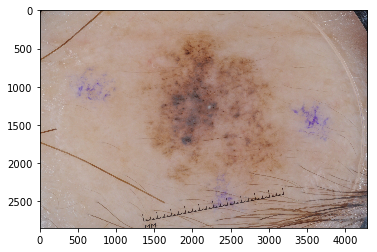

In [175]:
import cv2
img = cv2.imread(test_files[25])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [164]:
test_predictions = model.predict(test_features_inception)
test_predictions_task1 = test_predictions[:,0]
test_predictions_task2 = test_predictions[:,2]

In [165]:
submission_inception = pd.DataFrame({'Id':test_files, 'task_1':test_predictions_task1,'task_2':test_predictions_task2})
pd.DataFrame.to_csv(submission_inception, '/Users/Srini/Documents/Data science/UDACITY DEEP LEARNING/dermatologist-ai/submission.csv', index=False)

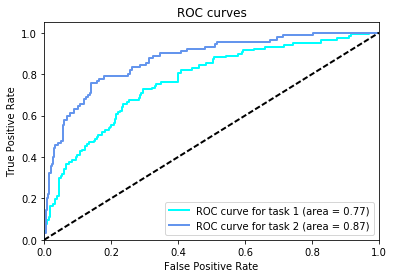

Category 1 Score: 0.768
Category 2 Score: 0.871
Category 3 Score: 0.820


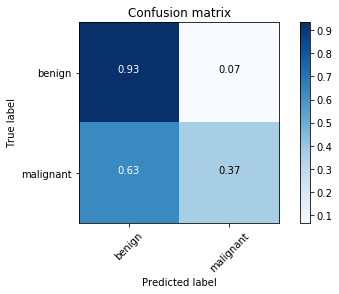

In [172]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from sklearn.metrics import roc_curve, auc, confusion_matrix

def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """

    # initialize dictionaries and array
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros(3)
    
    # prepare for figure
    plt.figure()
    colors = ['aqua', 'cornflowerblue']

    # for both classification tasks (categories 1 and 2)
    for i in range(2):
        # obtain ROC curve
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i])
        # obtain ROC AUC
        roc_auc[i] = auc(fpr[i], tpr[i])
        # plot ROC curve
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label='ROC curve for task {d} (area = {f:.2f})'.format(d=i+1, f=roc_auc[i]))
    # get score for category 3
    roc_auc[2] = np.average(roc_auc[:2])
    
    # format figure
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()
    
    # print scores
    for i in range(3):
        print('Category {d} Score: {f:.3f}'. format(d=i+1, f=roc_auc[i]))

def plot_confusion_matrix(y_true, y_pred, thresh, classes):
    """
    This function plots the (normalized) confusion matrix.
    """

    # obtain class predictions from probabilities
    y_pred = (y_pred>=thresh)*1
    # obtain (unnormalized) confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

if __name__ == "__main__":

    preds_path = sys.argv[1]
    
    thresh = 0.5

    # get ground truth labels for test dataset
    truth = pd.read_csv('ground_truth.csv')
    y_true = truth.as_matrix(columns=["task_1", "task_2"])

    # get model predictions for test dataset
    y_pred = pd.read_csv('submission.csv')
    y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])

    # plot ROC curves and print scores
    plot_roc_auc(y_true, y_pred)
    # plot confusion matrix
    classes = ['benign', 'malignant']
    plot_confusion_matrix(y_true[:,0], y_pred[:,0], thresh, classes)

